In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [2]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
    
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

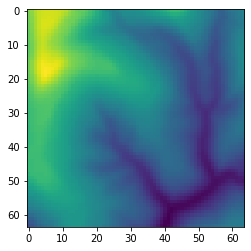

In [4]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [5]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [6]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, 3, padding=1),       
        nn.ReLU(),        
        nn.Conv2d(out_n, out_n, 3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)      
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_2(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_3(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_4(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        return mu + std * esp
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [7]:
vae = VAE().cuda()

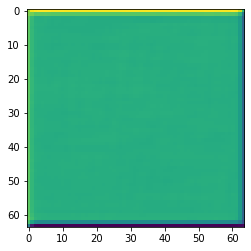

In [8]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [180]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(204.3071, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(101.6556, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(86.5924, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(39.2578, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(44.3239, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(61.5136, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(35.7183, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(55.6938, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(131.0282, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(53.2788, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(55.3861, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(136.6671, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(68.2166, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(171.7714, device='cuda:0', grad_fn=<AddBackward

In [12]:
torch.cuda.empty_cache()

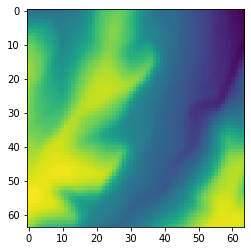

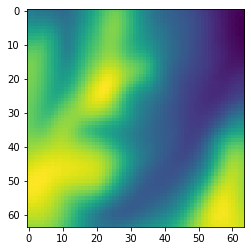

In [183]:
x = dataset[900].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [186]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [9]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

In [10]:
xs = []
for data in dataset:
    mu, logvar = vae.encode(data.cuda().view(1, 1, 64, 64))
    code = vae.reparametrize(mu, logvar)
    xs.append(code.cpu().detach()[0])

In [11]:
codes = torch.cat(xs).view(-1, 64)

In [12]:
codes[2]

tensor([ 0.0179,  0.5248,  0.5995, -0.2332,  0.9226,  1.1699, -0.2577,  1.2006,
         0.3864,  0.0528, -0.3740,  0.3108, -0.3655,  1.3439, -0.0973, -0.1809,
        -0.0715, -0.3428, -0.3667, -0.2862,  0.4587, -0.2966,  0.1044,  0.7858,
        -0.7512,  0.3400,  0.3330, -0.0417,  0.2687,  0.4898,  0.6360, -0.1558,
        -0.0178,  0.4267,  0.1215, -0.1503,  0.7429, -0.4153,  0.5452, -0.1924,
        -0.3949, -0.2135, -0.2323,  0.4197,  0.5779, -0.2624,  0.7272,  0.3086,
         0.1668, -0.9119, -0.3421, -0.5891,  0.4094, -0.0496,  0.1448, -0.3295,
         0.3214,  0.7292,  0.0117, -0.2561,  0.1513, -0.2074,  0.2728, -1.1840])

In [13]:
mean = codes.mean(axis=0)
std = codes.std(axis=0)

In [14]:
mean

tensor([ 5.3089e-02, -4.2636e-02,  2.0094e-01,  3.2733e-02,  4.7809e-02,
        -3.1791e+00,  1.6727e-01, -2.2469e+00, -1.3260e-03, -2.4213e-02,
         1.1212e-02,  3.1502e-03,  2.0320e-02, -6.0280e-03,  8.0128e-02,
        -1.7863e-02,  2.1956e-02, -1.7447e-01,  1.8627e-02,  4.5987e-02,
         6.4765e-02, -3.5847e-02,  7.5606e-03,  4.3136e-04, -4.0146e-02,
        -8.4499e-02,  2.3832e-02,  3.6866e-02, -1.0954e-02,  4.7451e-02,
         2.3790e-02, -8.1963e-02, -2.3067e-02,  1.2053e-02,  3.3463e-02,
         1.4750e-02,  1.8026e-02, -3.4578e-01, -4.4187e-03, -1.1002e-02,
        -4.5337e-02, -1.4915e-01,  3.3098e-02, -1.1704e-02,  8.1841e-02,
        -6.9751e-02,  2.0955e-03,  1.7867e-02,  6.4716e-02, -9.0569e-02,
        -4.3515e-02, -1.0478e-02, -1.1996e-02,  7.6109e-03, -3.2681e-02,
        -5.4050e-02, -4.9919e-02, -1.3009e-02, -1.3312e-02,  6.2384e-02,
         8.3055e-02, -8.4592e-03,  5.9196e-02,  4.4154e-02])

In [15]:
std

tensor([0.2968, 0.3461, 0.3691, 0.5188, 0.3499, 3.7724, 0.3693, 2.8419, 0.2559,
        0.2817, 0.2949, 0.2721, 0.4292, 0.6171, 0.3499, 0.2766, 0.2613, 0.2973,
        0.2627, 0.3102, 0.3198, 0.3665, 0.2910, 0.3264, 0.2929, 0.3434, 0.2943,
        0.2935, 0.2539, 0.2643, 0.2660, 0.4690, 0.3263, 0.5662, 0.2852, 0.2654,
        0.5269, 0.4214, 0.2657, 0.2866, 0.4003, 0.3356, 0.2639, 0.3599, 0.4375,
        0.4590, 0.3805, 0.2603, 0.2988, 0.3304, 0.2867, 0.3277, 0.3149, 0.3430,
        0.3031, 0.3327, 0.3737, 0.3564, 0.2580, 0.3001, 0.3248, 0.2600, 0.3085,
        0.3300])

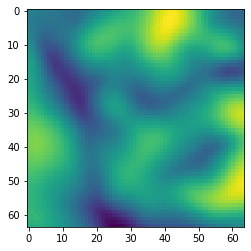

In [125]:
# Generator
mean = torch.tensor([ 5.3089e-02, -4.2636e-02,  2.0094e-01,  3.2733e-02,  4.7809e-02,
                     -3.1791e+00,  1.6727e-01, -2.2469e+00, -1.3260e-03, -2.4213e-02,
                      1.1212e-02,  3.1502e-03,  2.0320e-02, -6.0280e-03,  8.0128e-02,
                     -1.7863e-02,  2.1956e-02, -1.7447e-01,  1.8627e-02,  4.5987e-02,
                      6.4765e-02, -3.5847e-02,  7.5606e-03,  4.3136e-04, -4.0146e-02,
                     -8.4499e-02,  2.3832e-02,  3.6866e-02, -1.0954e-02,  4.7451e-02,
                      2.3790e-02, -8.1963e-02, -2.3067e-02,  1.2053e-02,  3.3463e-02,
                      1.4750e-02,  1.8026e-02, -3.4578e-01, -4.4187e-03, -1.1002e-02,
                     -4.5337e-02, -1.4915e-01,  3.3098e-02, -1.1704e-02,  8.1841e-02,
                     -6.9751e-02,  2.0955e-03,  1.7867e-02,  6.4716e-02, -9.0569e-02,
                     -4.3515e-02, -1.0478e-02, -1.1996e-02,  7.6109e-03, -3.2681e-02,
                     -5.4050e-02, -4.9919e-02, -1.3009e-02, -1.3312e-02,  6.2384e-02,
                      8.3055e-02, -8.4592e-03,  5.9196e-02,  4.4154e-02])

std = torch.tensor([0.2968, 0.3461, 0.3691, 0.5188, 0.3499, 3.7724, 0.3693, 2.8419, 0.2559,
                    0.2817, 0.2949, 0.2721, 0.4292, 0.6171, 0.3499, 0.2766, 0.2613, 0.2973,
                    0.2627, 0.3102, 0.3198, 0.3665, 0.2910, 0.3264, 0.2929, 0.3434, 0.2943,
                    0.2935, 0.2539, 0.2643, 0.2660, 0.4690, 0.3263, 0.5662, 0.2852, 0.2654,
                    0.5269, 0.4214, 0.2657, 0.2866, 0.4003, 0.3356, 0.2639, 0.3599, 0.4375,
                    0.4590, 0.3805, 0.2603, 0.2988, 0.3304, 0.2867, 0.3277, 0.3149, 0.3430,
                    0.3031, 0.3327, 0.3737, 0.3564, 0.2580, 0.3001, 0.3248, 0.2600, 0.3085,
                    0.3300])

code = torch.FloatTensor(1, 64).normal_()
code = mean + std * code

out = vae.decode(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

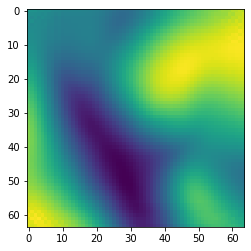

In [126]:
part = out[0][0][0:32, 0:32]
t = F.interpolate(part.view(1, 1, 32, 32), 64)

out_part = vae(t)
plt.imshow(out_part[0].view(64, 64).cpu().detach().numpy())
plt.show()

out2 = out_part[0]

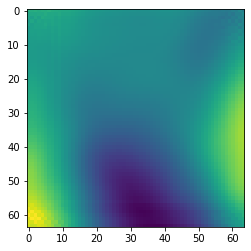

In [127]:
part2 = out2[0][0][0:32, 0:32]
t2 = F.interpolate(part2.view(1, 1, 32, 32), 64)

out_part2 = vae(t2)
plt.imshow(out_part2[0].view(64, 64).cpu().detach().numpy())
plt.show()

out3 = out_part2[0]

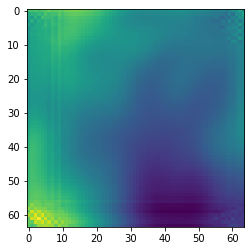

In [128]:
part3 = out3[0][0][0:32, 0:32]
t3 = F.interpolate(part3.view(1, 1, 32, 32), 64)

out_part3 = vae(t3)
plt.imshow(out_part3[0].view(64, 64).cpu().detach().numpy())
plt.show()

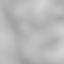

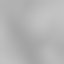

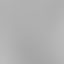

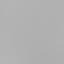

In [150]:
display(transforms.ToPILImage()(out[0].cpu()))
display(transforms.ToPILImage()(out_part[0][0].cpu()))
display(transforms.ToPILImage()(out_part2[0][0].cpu()))
display(transforms.ToPILImage()(out_part3[0][0].cpu()))